In [52]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os
import json

In [53]:
# File paths (replace with actual paths to the three largest JSON files)
DATA_FILES = [
    'C://Users//ruhik//OneDrive//Desktop//Assign//File-1.json',
    'C://Users//ruhik//OneDrive//Desktop//Assign//File-2.json',
    'C://Users//ruhik//OneDrive//Desktop//Assign//File-3.json'
]

In [54]:
# Define action types to extract from JSON
ACTION_TYPES = ['deposits', 'borrows', 'repays', 'withdraws', 'liquidations']

# Load and combine JSON data
def load_data(file_paths):
    all_transactions = []
    
    for file in file_paths:
        try:
            with open(file, 'r') as f:
                data = json.load(f)
            
            # Extract transactions for each action type
            for action in ACTION_TYPES:
                if action not in data:
                    print(f"Warning: '{action}' key not found in {file}")
                    continue
                
                for event in data[action]:
                    # Map JSON fields to a flat structure
                    transaction = {
                        'wallet_address': event['account']['id'],
                        'action': action[:-1] if action.endswith('s') else action,  # e.g., "deposits" -> "deposit"
                        'amount': float(event['amount']),
                        'timestamp': pd.to_datetime(int(event['timestamp']), unit='s')
                    }
                    all_transactions.append(transaction)
        
        except Exception as e:
            print(f"Error loading {file}: {e}")
    if not all_transactions:
        raise ValueError("No transactions loaded")
    
    return pd.DataFrame(all_transactions)
    

In [55]:
# Feature engineering
def engineer_features(data):
    required_cols = ['wallet_address', 'action', 'amount', 'timestamp']
    for col in required_cols:
        if col not in data.columns:
            raise ValueError(f"Column {col} missing from dataset. Available columns: {data.columns}")
    
    features = {}
    
    for wallet in data['wallet_address'].unique():
        wallet_data = data[data['wallet_address'] == wallet]
        features[wallet] = {}
        
        # Extract amounts for each action type
        deposits = wallet_data[wallet_data['action'] == 'deposit']['amount']
        borrows = wallet_data[wallet_data['action'] == 'borrow']['amount']
        repayments = wallet_data[wallet_data['action'] == 'repay']['amount']
        
        # Compute features
        features[wallet]['total_deposits'] = deposits.sum() if not deposits.empty else 0
        features[wallet]['total_borrows'] = borrows.sum() if not borrows.empty else 0
        features[wallet]['total_repayments'] = repayments.sum() if not repayments.empty else 0
        features[wallet]['num_liquidations'] = len(wallet_data[wallet_data['action'] == 'liquidation'])
        features[wallet]['repayment_ratio'] = (
            features[wallet]['total_repayments'] / features[wallet]['total_borrows']
            if features[wallet]['total_borrows'] > 0 else 1.0
        )
        features[wallet]['borrow_to_deposit_ratio'] = (
            features[wallet]['total_borrows'] / features[wallet]['total_deposits']
            if features[wallet]['total_deposits'] > 0 else 0.0
        )
        time_span = (wallet_data['timestamp'].max() - wallet_data['timestamp'].min()).days
        features[wallet]['txn_frequency'] = (
            len(wallet_data) / time_span if time_span > 0 else len(wallet_data)
        )
        intervals = wallet_data['timestamp'].sort_values().diff().dt.total_seconds() / 3600
        features[wallet]['avg_txn_interval'] = intervals.mean() if not intervals.empty else 0
        features[wallet]['num_unique_actions'] = wallet_data['action'].nunique()
    
    return pd.DataFrame.from_dict(features, orient='index')

In [56]:
import matplotlib.pyplot as plt

def log_normalize(series):
    shifted = series - series.min()
    return np.log1p(shifted) / (np.log1p(shifted.max()) + 1e-10)

def compute_scores(feature_df):
    # Handle missing or infinite values
    feature_df = feature_df.fillna(0).replace([np.inf, -np.inf], 0)

    # Log-normalize skewed features
    features_to_log = ['total_deposits', 'total_borrows', 'total_repayments', 'txn_frequency']
    for col in features_to_log:
        feature_df[f'{col}_log'] = log_normalize(feature_df[col])

    # Normalize remaining features linearly
    def minmax(col):
        return (feature_df[col] - feature_df[col].min()) / (feature_df[col].max() - feature_df[col].min() + 1e-10)

    feature_df['repayment_ratio_norm'] = minmax('repayment_ratio')
    feature_df['borrow_to_deposit_ratio_norm'] = minmax('borrow_to_deposit_ratio')
    feature_df['avg_txn_interval_norm'] = minmax('avg_txn_interval')
    feature_df['num_liquidations_norm'] = minmax('num_liquidations')
    feature_df['num_unique_actions_norm'] = minmax('num_unique_actions')

    # Weighted scoring
    weights = {
        'total_deposits_log': 0.2,
        'total_borrows_log': 0.1,
        'total_repayments_log': 0.2,
        'txn_frequency_log': 0.1,
        'repayment_ratio_norm': 0.15,
        'borrow_to_deposit_ratio_norm': -0.05,
        'avg_txn_interval_norm': -0.05,
        'num_liquidations_norm': -0.15,
        'num_unique_actions_norm': 0.1
    }

    feature_df['raw_score'] = 0
    for feat, weight in weights.items():
        feature_df['raw_score'] += feature_df[feat] * weight

    # Non-linear score stretch using percentile rank
    feature_df['score'] = feature_df['raw_score'].rank(pct=True).apply(lambda x: x ** 0.5) * 100

    # 📊 Score histogram (optional)
    print("\n[INFO] Final Score Distribution:")
    print(feature_df['score'].describe())

    plt.figure(figsize=(8, 4))
    feature_df['score'].hist(bins=50, color='mediumseagreen', edgecolor='black')
    plt.title("Wallet Credit Score Distribution")
    plt.xlabel("Score (0–100)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return feature_df


In [57]:
# Generate outputs
def generate_outputs(feature_df):
    # Save top 1000 wallets
    top_1000 = feature_df[['score']].nlargest(1000, 'score')
    top_1000.to_csv('top_1000_wallets.csv')
    
    # Analyze top and bottom wallets
    top_wallets = feature_df.nlargest(5, 'score')
    bottom_wallets = feature_df.nsmallest(5, 'score')
    
    # Save analysis data
    with open('wallet_analysis_data.txt', 'w') as f:
        f.write("Top 5 Wallets:\n")
        for wallet, row in top_wallets.iterrows():
            f.write(f"Wallet {wallet[:8]}...: Score={row['score']:.2f}, Deposits={row['total_deposits']:.2e}, "
                    f"Repayment Ratio={row['repayment_ratio']:.2f}, Liquidations={row['num_liquidations']}\n")
        f.write("\nBottom 5 Wallets:\n")
        for wallet, row in bottom_wallets.iterrows():
            f.write(f"Wallet {wallet[:8]}...: Score={row['score']:.2f}, Deposits={row['total_deposits']:.2e}, "
                    f"Repayment Ratio={row['repayment_ratio']:.2f}, Liquidations={row['num_liquidations']}\n")
    
    return top_wallets, bottom_wallets


[INFO] Final Score Distribution:
count    13484.000000
mean        66.753382
std         23.332321
min          0.861173
25%         50.005562
50%         70.713300
75%         86.603611
max        100.000000
Name: score, dtype: float64


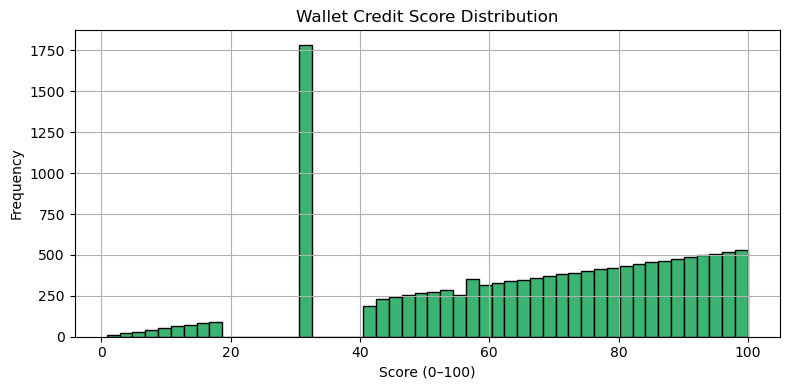

In [58]:
# Main execution
def main():
    data = load_data(DATA_FILES)
    feature_df = engineer_features(data)
    feature_df = compute_scores(feature_df)
    generate_outputs(feature_df)

if __name__ == '__main__':
    main()